# Demo of NF-HEDM reconstruction using g-force

In [1]:
# import os 
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
import sys
sys.path.insert(0, '..')
import numpy as np
import matplotlib.pyplot as plt
import pickle
# customized module

from hexomap import reconstruction  # g-force caller
from hexomap import MicFileTool     # io for reconstruction rst
from hexomap import IntBin          # io for binary image (reduced data)

## Calibration with Au cube

integrate quaterdegree binary images into one degreee

> quater degree is harder to get geometry parameters


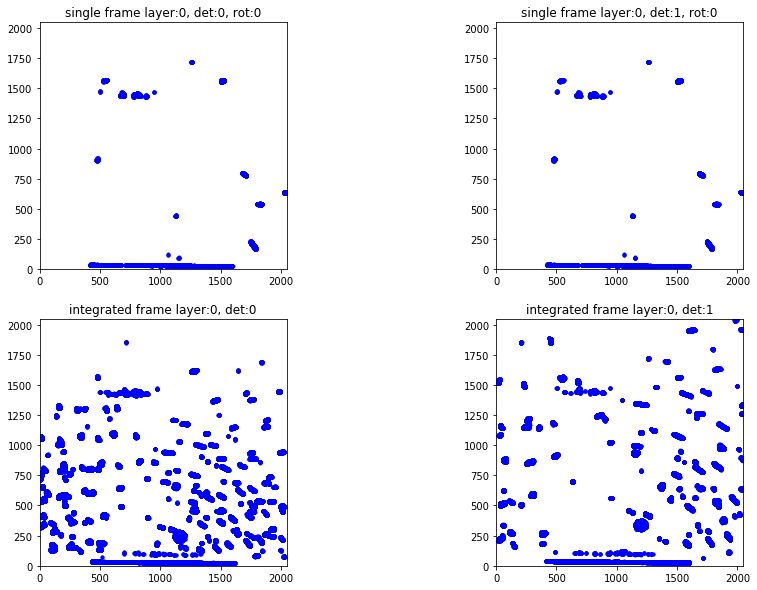

In [3]:
from hexomap import IntBin          # io for binary image (reduced data)
import matplotlib.pyplot as plt
import numpy as np
rawInitial = '../examples/johnson_aug18_demo/Au_reduced_1degree//Au_int_1degree_suter_aug18_z'
NRot = 30   # only number of images to display, doen't have to be all images(no need set to 180 or 720.can be some thing like 10)
NDet = 2
idxLayer = 0
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,10)
figure, ax = plt.subplots(2, NDet)
for idxDet in range(NDet):
    # single frame
    idxRot = 0  # index of rotation (0~719)
    b=IntBin.ReadI9BinaryFiles(f'{rawInitial}{idxLayer}_{0:06d}.bin{1}'.format(int(idxRot),idxDet))
    ax[0,idxDet].plot(2047-b[0],2047-b[1],'b.')
    ax[0,idxDet].axis('scaled')
    ax[0,idxDet].set_xlim((0,2048))
    ax[0,idxDet].set_ylim((0,2048))
    ax[0,idxDet].set_title(f'single frame layer:{idxLayer}, det:{idxDet}, rot:{idxRot}')
    
    # integrated frame:
    lX = []
    lY = []
    for idxRot in range(NRot):
        #print(b)
        b = IntBin.ReadI9BinaryFiles(f'{rawInitial}{idxLayer}_{idxRot:06d}.bin{idxDet}')
        lX.append(b[0])
        lY.append(b[1])
    aX = np.concatenate(lX)
    aY = np.concatenate(lY)
    ax[1,idxDet].plot(2047-aX,2047-aY,'b.')  
    ax[1,idxDet].axis('scaled')
    ax[1,idxDet].set_xlim((0,2048))
    ax[1,idxDet].set_ylim((0,2048))
    ax[1,idxDet].set_title(f'integrated frame layer:{idxLayer}, det:{idxDet}')

plt.show()

## blind search for geometry parameters
# we need to specify a region that contain sample

In [6]:
import sys
sys.path.insert(0, '..')
from hexomap import config
import numpy as np

Au_Config={
    'micsize' : np.array([20, 20]),
    'micVoxelSize' : 0.001,
    'micShift' : np.array([0.0, 0.0, 0.0]),
    'expdataNDigit' : 6,
    'energy' : 65.351,      #55.587 # in kev
    'sample' : 'gold',
    'maxQ' : 9,
    'etalimit' : 81 / 180.0 * np.pi,
    'NRot' : 180,
    'NDet' : 2,
    'searchBatchSize' : 6000,
    'reverseRot' : True,          # for aero, is True, for rams: False
    'detL' : np.array([[ 4.5, 6.5]]),
    'detJ' : np.array([[1020.4672, 1035.6063]]),
    'detK' : np.array([[1995.8868, 1990.6409]]),
    'detRot' : np.array([[[90, 90, 0],
                  [90, 90, 0]]]),
    'fileBin' : '../examples/johnson_aug18_demo/Au_reduced_1degree//Au_int_1degree_suter_aug18_z',
    'fileBinDigit' : 6,
    'fileBinDetIdx' : np.array([0, 1]),
    'fileBinLayerIdx' : 0,
    '_initialString' : 'demo_gold_'}
    
c = config.Config(**Au_Config)
print(c)


Configurations:
NDet                           2
NRot                           180
_initialString                 demo_gold_
detJ                           [[1020.4672 1035.6063]]
detK                           [[1995.8868 1990.6409]]
detL                           [[4.5 6.5]]
detRot                         [[[90 90  0]
  [90 90  0]]]
energy                         65.351
etalimit                       1.413716694115407
expdataNDigit                  6
fileBin                        ../examples/johnson_aug18_demo/Au_reduced_1degree//Au_int_1degree_suter_aug18_z
fileBinDetIdx                  [0 1]
fileBinDigit                   6
fileBinLayerIdx                0
maxQ                           9
micShift                       [0. 0. 0.]
micVoxelSize                   0.001
micsize                        [20 20]
reverseRot                     True
sample                         gold
searchBatchSize                6000




In [7]:
from hexomap import reconstruction
import numpy as np
try:
    S.clean_up()
except NameError:
    pass

S = reconstruction.Reconstructor_GPU()
print(c)
S.load_config(c)
c.detL, c.detJ, c.detK, c.detRot = S.blind_search_parameter(centerL=np.array(c.detL), rotOptimization=True)
print(c)
print(c.detL, c.detJ, c.detK, c.detRot)
c.save('demo_gold_blind_search_0.h5')


Configurations:
NDet                           2
NRot                           180
_initialString                 demo_gold_
detJ                           [[1020.4672 1035.6063]]
detK                           [[1995.8868 1990.6409]]
detL                           [[4.5 6.5]]
detRot                         [[[90 90  0]
  [90 90  0]]]
energy                         65.351
etalimit                       1.413716694115407
expdataNDigit                  6
fileBin                        ../examples/johnson_aug18_demo/Au_reduced_1degree//Au_int_1degree_suter_aug18_z
fileBinDetIdx                  [0 1]
fileBinDigit                   6
fileBinLayerIdx                0
maxQ                           9
micShift                       [0. 0. 0.]
micVoxelSize                   0.001
micsize                        [20 20]
reverseRot                     True
sample                         gold
searchBatchSize                6000


set Q automatically to 9
 exp data loaded, shape is: (1781216, 4).

Loading configuration from demo_gold_blind_search_0.h5

Configurations:
NDet                           2
NRot                           180
_initialString                 demo_gold_
detJ                           [[1013.3554 1025.8002]]
detK                           [[2016.0343 2012.6452]]
detL                           [[4.5151 6.5151]]
detRot                         [[[ 9.0000e+01  8.9999e+01  2.2231e-03]
  [ 9.0000e+01  9.0000e+01 -1.5179e-03]]]
energy                         65.351
etalimit                       1.413716694115407
expdataNDigit                  6
fileBin                        ../examples/johnson_aug18_demo/Au_reduced_1degree//Au_int_1degree_suter_aug18_z
fileBinDetIdx                  [0 1]
fileBinDigit                   6
fileBinLayerIdx                0
maxQ                           9
micShift                       [0. 0. 0.]
micVoxelSize                   0.005
micsize                        [20 20]
reverseRot                     True
sample                   

/home/reeju/.conda/envs/HEXOMAPenv/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


set Q automatically to 9
 exp data loaded, shape is: (1781216, 4).amples/johnson_aug18_demo/Au_reduced_1degree//Au_int_1degree_suter_aug18_z0_000179.bin1
=============start of copy exp data to gpu ===========
start of create data on cpu ram
=============start of copy exp data to CPU ===========
assuming same type of detector in different distances
=============end of copy exp data to CPU ===========
start of creating texture memory
end of creating texture memory
=============end of copy exp data to gpu ===========
==========start of reconstruction======== 

 number of flood fills: 0 prog: 0000001/0000400, conf: 0.464789, pkcnt: 71, euler: [206.695   51.9252  98.6225]
start of post processing, moving grain boundaries untile stable
 number of post process iteration: 2, number of voxel revisited: 13
 post process takes is 0.2819385528564453 seconds
===========end of reconstruction========== 

SourceModule time 22.693119140625 seconds.
saved as npy format


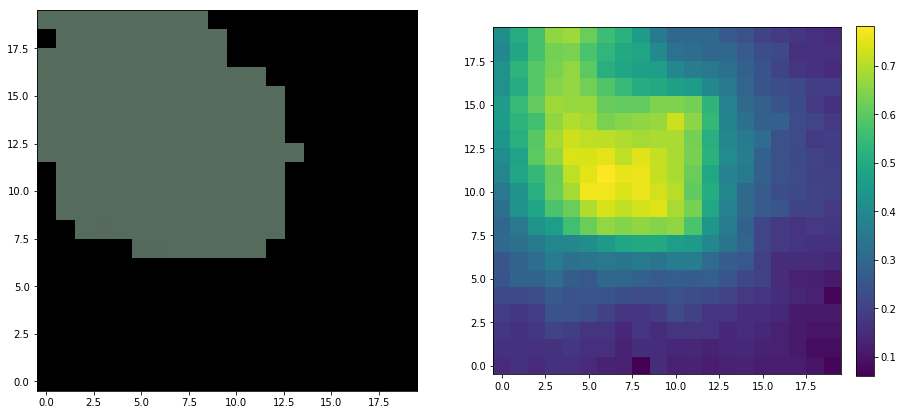

In [8]:
# load blind search zero and recon
import sys
sys.path.insert(0, '..')
import numpy as np
from hexomap import config
from hexomap import reconstruction  # g-force caller
from hexomap import MicFileTool     # io for reconstruction rst
from hexomap import IntBin          # io for binary image (reduced data)
c = config.Config().load('demo_gold_blind_search_0.h5')
c.micsize = np.array([20, 20])
c.micVoxelSize = 0.005
c.micShift = np.array([0.0, 0.0, 0.0])
print(c)

try:
    S.clean_up()
except NameError:
    pass

S = reconstruction.Reconstructor_GPU()
S.load_config(c)
S.serial_recon_multi_stage()

MicFileTool.plot_mic_and_conf(S.squareMicData, 0.4)

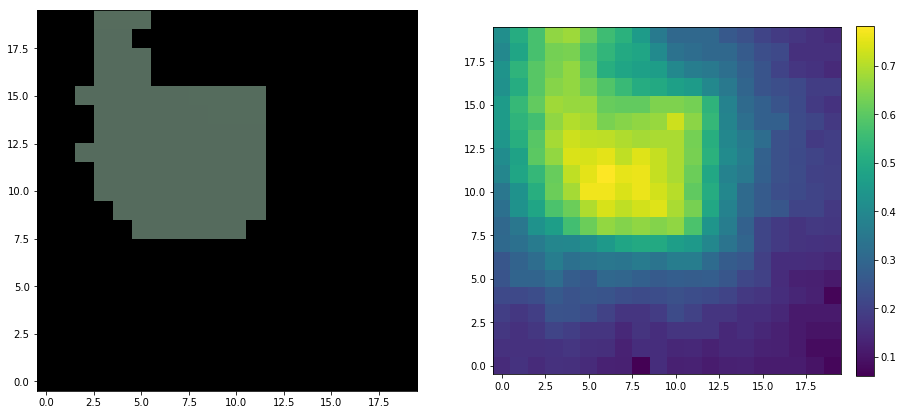

In [9]:
MicFileTool.plot_mic_and_conf(S.squareMicData, 0.6)

 loss: 0.3396, sumdp: 0.0665, centerL: [[4.5151 6.5151]], centerJ: 1008.36 1025.80, centerK: 2016.03 2012.65.   
 loss: 0.3305, sumdp: 0.0657, centerL: [[4.5151 6.5151]], centerJ: 1008.36 1025.80, centerK: 2016.03 2014.65.   
 loss: 0.3186, sumdp: 0.0558, centerL: [[4.5151 6.5151]], centerJ: 1013.31 1025.80, centerK: 2016.03 2014.65.   
 loss: 0.2978, sumdp: 0.0564, centerL: [[4.5151 6.5151]], centerJ: 1013.31 1029.85, centerK: 2016.03 2014.65.   
 loss: 0.2936, sumdp: 0.0478, centerL: [[4.5151 6.5151]], centerJ: 1008.40 1029.85, centerK: 2016.03 2014.65.   
 loss: 0.2863, sumdp: 0.0435, centerL: [[4.5151 6.5151]], centerJ: 1008.40 1026.24, centerK: 2016.03 2014.65.   
 loss: 0.2806, sumdp: 0.0174, centerL: [[4.5151 6.5151]], centerJ: 1008.40 1027.95, centerK: 2016.03 2014.65.   
 loss: 0.2779, sumdp: 0.0174, centerL: [[4.5151 6.5151]], centerJ: 1008.40 1027.95, centerK: 2015.58 2014.65.   
 loss: 0.2732, sumdp: 0.0143, centerL: [[4.5151 6.5151]], centerJ: 1008.40 1027.95, centerK: 201

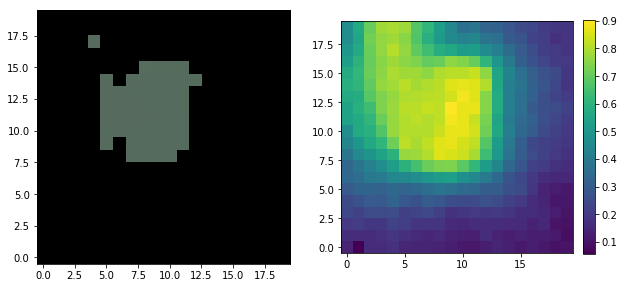

In [10]:
# first iteration of twiddle:
# this cell can be repeated until find good parameters, i.e. sample region confidence>0.9

#### make as mask, twiddle process will only performed on selected voxels ####
import time
squareMic = S.squareMicData
maskFinal = np.zeros(c.micsize)
maskFinal[squareMic[:,:,6]>0.6] = 1  # choose this value so that there will be reasonable amount of voxel for twiddle search
x,y = np.where(maskFinal==1)
aIdxVoxel = x * maskFinal.shape[0] + y

aIdxVoxel = np.random.choice(aIdxVoxel,100)
start = time.time()
c.detL, c.detJ, c.detK, c.detRot = S.twiddle_refine(aIdxVoxel,c.detL, c.detJ, c.detK, c.detRot)
end = time.time()
print(f'twiddle takes: {end- start} seconds')
print(c.detL, c.detJ, c.detK, c.detRot)
c.save('../examples/johnson_aug18_demo/demo_gold_twiddle_0.h5')

############ reconstruct and see result ############
S.load_config(c)
S.serial_recon_multi_stage()

################ visualize result ##################
from hexomap import MicFileTool
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)
import numpy as np
MicFileTool.plot_mic_and_conf(S.squareMicData, 0.8)

In [ ]:
# first iteration of twiddle:
# this cell can be repeated until find good parameters, i.e. sample region confidence>0.9

#### make as mask, twiddle process will only performed on selected voxels ####
import time
squareMic = S.squareMicData
maskFinal = np.zeros(c.micsize)
maskFinal[squareMic[:,:,6]>0.7] = 1  # choose this value so that there will be reasonable amount of voxel for twiddle search
x,y = np.where(maskFinal==1)
aIdxVoxel = x * maskFinal.shape[0] + y

aIdxVoxel = np.random.choice(aIdxVoxel,100)
start = time.time()
c.detL, c.detJ, c.detK, c.detRot = S.twiddle_refine(aIdxVoxel,c.detL, c.detJ, c.detK, c.detRot)
end = time.time()
print(f'twiddle takes: {end- start} seconds')
print(c.detL, c.detJ, c.detK, c.detRot)
c.save('../examples/johnson_aug18_demo/demo_gold_twiddle_1.h5')

############ reconstruct and see result ############
S.load_config(c)
S.serial_recon_multi_stage()

################ visualize result ##################
from hexomap import MicFileTool
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)
import numpy as np
MicFileTool.plot_mic_and_conf(S.squareMicData, 0.8)

In [ ]:
# first iteration of twiddle:
# this cell can be repeated until find good parameters, i.e. sample region confidence>0.9

#### make as mask, twiddle process will only performed on selected voxels ####
import time
squareMic = S.squareMicData
maskFinal = np.zeros(c.micsize)
maskFinal[squareMic[:,:,6]>0.8] = 1  # choose this value so that there will be reasonable amount of voxel for twiddle search
x,y = np.where(maskFinal==1)
aIdxVoxel = x * maskFinal.shape[0] + y

aIdxVoxel = np.random.choice(aIdxVoxel,100)
start = time.time()
c.detL, c.detJ, c.detK, c.detRot = S.twiddle_refine(aIdxVoxel,c.detL, c.detJ, c.detK, c.detRot)
end = time.time()
print(f'twiddle takes: {end- start} seconds')
print(c.detL, c.detJ, c.detK, c.detRot)
c.save('../examples/johnson_aug18_demo/demo_gold_twiddle_2.h5')

############ reconstruct and see result ############
S.load_config(c)
S.serial_recon_multi_stage()

################ visualize result ##################
from hexomap import MicFileTool
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)
import numpy as np
MicFileTool.plot_mic_and_conf(S.squareMicData, 0.8)

In [ ]:
MicFileTool.plot_mic_and_conf(S.squareMicData, 0.85)

In [ ]:
# first iteration of twiddle:
# this cell can be repeated until find good parameters, i.e. sample region confidence>0.9

#### make as mask, twiddle process will only performed on selected voxels ####
import time
squareMic = S.squareMicData
maskFinal = np.zeros(c.micsize)
maskFinal[squareMic[:,:,6]>0.85] = 1  # choose this value so that there will be reasonable amount of voxel for twiddle search
x,y = np.where(maskFinal==1)
aIdxVoxel = x * maskFinal.shape[0] + y

aIdxVoxel = np.random.choice(aIdxVoxel,100)
start = time.time()
c.detL, c.detJ, c.detK, c.detRot = S.twiddle_refine(aIdxVoxel,c.detL, c.detJ, c.detK, c.detRot)
end = time.time()
print(f'twiddle takes: {end- start} seconds')
print(c.detL, c.detJ, c.detK, c.detRot)
c.save('../examples/johnson_aug18_demo/demo_gold_twiddle_3.h5')

############ reconstruct and see result ############
S.load_config(c)
S.serial_recon_multi_stage()

################ visualize result ##################
from hexomap import MicFileTool
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)
import numpy as np
MicFileTool.plot_mic_and_conf(S.squareMicData, 0.8)

# reconstruct iron dataset

In [ ]:
# step 1: reduce binray data set for fast initial guess

# fnbase = '/home/hedm/work/suter_aug18/SB1_v1_v2_boxbeam/SB1_postheat_restart_z0_'

# output = fnbase

# ImagePar={'nDetectors':2,
#         'sBinFilePrefix':'/home/hedm/work/suter_aug18/SB1_v1_v2_boxbeam/SB1_postheat_restart_V1/SB1_postheat_restart_V1__z0_',
#         'nReductionNSUM':4,
#         'nBinFileIndexStart':0,
#         'fOmegaStart':-90,
#         'fOmegaStop':90,
#         }
# IntBin.IntegrateBinFiles(ImagePar,output)

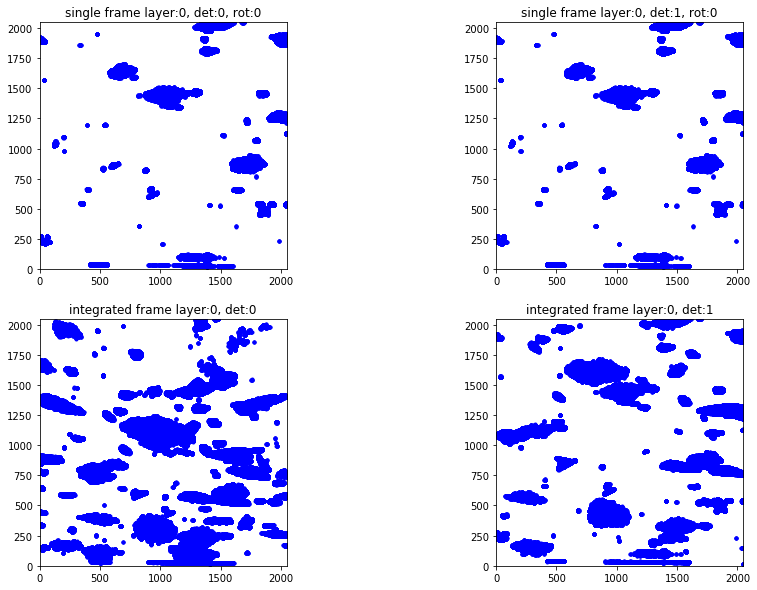

In [12]:
from hexomap import IntBin
import matplotlib.pyplot as plt
import numpy as np
rawInitial = '../examples/johnson_aug18_demo/SB1_postheat_restart_V1_1degree/SB1_V1_1degree_z'
NRot = 3   # only number of images to display, doen't have to be all images(no need set to 180 or 720.can be some thing like 10)
NDet = 2
idxLayer = 0
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,10)
figure, ax = plt.subplots(2, NDet)
for idxDet in range(NDet):
    # single frame
    idxRot = 0  # index of rotation (0~719)
    b=IntBin.ReadI9BinaryFiles(f'{rawInitial}{idxLayer}_{0:06d}.bin{1}'.format(int(idxRot),idxDet))
    ax[0,idxDet].plot(2047-b[0],2047-b[1],'b.')
    ax[0,idxDet].axis('scaled')
    ax[0,idxDet].set_xlim((0,2048))
    ax[0,idxDet].set_ylim((0,2048))
    ax[0,idxDet].set_title(f'single frame layer:{idxLayer}, det:{idxDet}, rot:{idxRot}')
    
    # integrated frame:
    lX = []
    lY = []
    for idxRot in range(NRot):
        #print(b)
        b = IntBin.ReadI9BinaryFiles(f'{rawInitial}{idxLayer}_{idxRot:06d}.bin{idxDet}')
        lX.append(b[0])
        lY.append(b[1])
    aX = np.concatenate(lX)
    aY = np.concatenate(lY)
    ax[1,idxDet].plot(2047-aX,2047-aY,'b.')  
    ax[1,idxDet].axis('scaled')
    ax[1,idxDet].set_xlim((0,2048))
    ax[1,idxDet].set_ylim((0,2048))
    ax[1,idxDet].set_title(f'integrated frame layer:{idxLayer}, det:{idxDet}')

plt.show()

In [ ]:
# # activate this cell if you want to specify specific GPU
# import os 
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [14]:
'''
    Reconstruct sample SB with parameters from gold sample
'''

import sys
sys.path.insert(0, '..')
from hexomap import config
import numpy as np

c_Au = config.Config().load('../examples/johnson_aug18_demo/demo_gold_twiddle_3.h5')

Fe_Config={
    'micsize' : np.array([150, 150]),
    'micVoxelSize' : 0.01,
    'micShift' : np.array([0.0, 0.0, 0.0]),
    'expdataNDigit' : 6,
    'energy' : 65.351,      #55.587 # in kev
    'sample' : 'iron_bcc',
    'maxQ' : 9,
    'etalimit' : 81 / 180.0 * np.pi,
    'NRot' : 180,
    'NDet' : 2,
    'searchBatchSize' : 6000,
    'reverseRot' : True,          # for aero, is True, for rams: False
    'detL' : c_Au.detL,
    'detJ' : c_Au.detJ,
    'detK' : c_Au.detK,
    'detRot' : c_Au.detRot,
    'fileBin' : '../examples/johnson_aug18_demo/SB1_postheat_restart_V1_1degree/SB1_V1_1degree_z',
    'fileBinDigit' : 6,
    'fileBinDetIdx' : np.array([0, 1]),
    'fileBinLayerIdx' : 0,
    '_initialString' : '../examples/johnson_aug18_demo/SB1_postheat_restart_V1_1degree'}
  
c = config.Config(**Fe_Config)
print(c)
c.save('../examples/johnson_aug18_demo/SB1_postheat_restart_V1_1degree_config.h5')

Loading configuration from ../examples/johnson_aug18_demo/demo_gold_twiddle_3.h5

Configurations:
NDet                           2
NRot                           180
_initialString                 ../examples/johnson_aug18_demo/SB1_postheat_restart_V1_1degree
detJ                           [[1010.7941 1027.4384]]
detK                           [[2015.9512 2014.3016]]
detL                           [[4.5357 6.5357]]
detRot                         [[[89.4856 89.5331 -0.5068]
  [89.4252 89.2257 -0.4551]]]
energy                         65.351
etalimit                       1.413716694115407
expdataNDigit                  6
fileBin                        ../examples/johnson_aug18_demo/SB1_postheat_restart_V1_1degree/SB1_V1_1degree_z
fileBinDetIdx                  [0 1]
fileBinDigit                   6
fileBinLayerIdx                0
maxQ                           9
micShift                       [0. 0. 0.]
micVoxelSize                   0.01
micsize                        [150 150]
revers

In [ ]:
# load blind search zero and recon
import sys
sys.path.insert(0, '/home/heliu/work/dev/HEXOMAP/')
import numpy as np
from hexomap import reconstruction  # g-force caller
from hexomap import MicFileTool     # io for reconstruction rst
from hexomap import IntBin          # io for binary image (reduced data)

################# configuration #########################
c= config.Config().load('../examples/johnson_aug18_demo/SB1_postheat_restart_V1_1degree_config.h5')
print(c)
################# reconstruction #########################
try:
    S.clean_up()
except NameError:
    pass
S = reconstruction.Reconstructor_GPU()
S.load_config(c)
S.serial_recon_multi_stage()
################# visualization #########################
MicFileTool.plot_mic_and_conf(S.squareMicData, 0.5)

Loading configuration from ../examples/johnson_aug18_demo/SB1_postheat_restart_V1_1degree_config.h5

Configurations:
NDet                           2
NRot                           180
_initialString                 ../examples/johnson_aug18_demo/SB1_postheat_restart_V1_1degree
detJ                           [[1010.7941 1027.4384]]
detK                           [[2015.9512 2014.3016]]
detL                           [[4.5357 6.5357]]
detRot                         [[[89.4856 89.5331 -0.5068]
  [89.4252 89.2257 -0.4551]]]
energy                         65.351
etalimit                       1.413716694115407
expdataNDigit                  6
fileBin                        ../examples/johnson_aug18_demo/SB1_postheat_restart_V1_1degree/SB1_V1_1degree_z
fileBinDetIdx                  [0 1]
fileBinDigit                   6
fileBinLayerIdx                0
maxQ                           9
micShift                       [0. 0. 0.]
micVoxelSize                   0.01
micsize                     

In [ ]:
MicFileTool.plot_mic_and_conf(S.squareMicData, 0.5)

## demonstrate using a mask

In [ ]:
# # step 2: start reconstruction with calibrated configuration (parameters)
# import reconstruction
# import MicFileTool
# import numpy as np
# import matplotlib.pyplot as plt
# import IntBin
# import pickle
# import scipy.ndimage as ndi
# # check result of parameter get from blind search:
# # NOET: in practice, might need more iterations for better configuration params
# with open('geometry_au_johnson_aug18_twiddle_1.p', 'rb') as input:
#     centerL, centerJ, centerK, centerRot  = pickle.load(input)

# ############ low resolution reconstruction
# S = reconstruction.Reconstructor_GPU()
# S.set_det_param(centerL, centerJ, centerK, centerRot) # set parameter
# S.set_Q(7)
# print(S.maxQ)

# S.FZFile = '/home/hedm/work/I9_test_data/Au_Mar17/DataFiles/MyFZ.dat'         # fundamental zone file
# S.set_sample('iron_bcc')
# S.energy = 65.351
# S.expDataInitial = '/home/hedm/work/suter_aug18/SB1_v1_v2_boxbeam/SB1_postheat_restart_V1_1degree/SB1_V1_1degree_z0_' # reduced binary data
# S.expdataNDigit = 6                                                       # number of digit in the binary file name
# imgsize = [15, 15]
# voxelSize = 0.1
# shift = [0.0, 0.0, 0.0]
# S.create_square_mic(imgsize,
#                     voxelsize=voxelSize,
#                     shift=shift,
#                    )# resolution of reconstruction and voxel size
# S.squareMicOutFile = 'demoSB1_V1_Z0_johnson_aug17_' \
#                     + f'{"x".join(map(str,imgsize))}_{voxelSize}' \
#                     + f'_shift_{"_".join(map(str, shift))}.npy' # output file name
# S.searchBatchSize = 6000   # number of orientations search at each iteration, larger number will take longer time.
# S.intensity_threshold = 2 # throw away peaks with intensity below this value
# S.recon_prepare(reverseRot=True)  # at 1ID, left hand rotation needs reverseRot=True
# S.serial_recon_multi_stage()

# #388seconds with verbose
# plt.rcParams["figure.figsize"] = (10,10)
# MicFileTool.plot_square_mic(S.squareMicData,0.6)
# MicFileTool.plot_conf_square_mic(S.squareMicData)

# ######### create mask
# mask_15_15 = np.load(S.squareMicOutFile)[:,:,6]>0.3
# #mask_30_30 = S.squareMicData[:,:,6]>0.5
# mask_150_15 = np.repeat(mask_15_15, 10, axis=0)
# mask_150_150 = np.repeat(mask_150_15, 10, axis=1)
# mask_150_150 = ndi.maximum_filter(mask_150_150,size=5)
# plt.imshow(mask_150_150.T, origin='lower')

# ######## high resolution reconstruction
# S = reconstruction.Reconstructor_GPU()
# S.set_det_param(centerL, centerJ, centerK, centerRot) # set parameter
# S.set_Q(7)
# print(S.maxQ)

# S.FZFile = '/home/hedm/work/I9_test_data/Au_Mar17/DataFiles/MyFZ.dat'         # fundamental zone file
# S.set_sample('iron_bcc')
# S.energy = 65.351
# S.expDataInitial = '/home/hedm/work/suter_aug18/SB1_v1_v2_boxbeam/SB1_postheat_restart_V1_1degree/SB1_V1_1degree_z0_' # reduced binary data
# S.expdataNDigit = 6 
# imgsize = [150, 150]
# voxelSize = 0.01
# shift = [0.0, 0.0, 0.0]
# S.create_square_mic(imgsize,
#                     voxelsize=voxelSize,
#                     shift=shift,
#                     mask=mask_150_150,
#                    )# resolution of reconstruction and voxel size
# S.squareMicOutFile = 'demoSB1_V1_Z0_johnson_aug17_' \
#                     + f'{"x".join(map(str,imgsize))}_{voxelSize}' \
#                     + f'_shift_{"_".join(map(str, shift))}.npy' # output file name
# S.searchBatchSize = 6000   # number of orientations search at each iteration, larger number will take longer time.
# S.intensity_threshold = 2 # throw away peaks with intensity below this value
# S.recon_prepare(reverseRot=True)  # at 1ID, left hand rotation needs reverseRot=True
# S.serial_recon_multi_stage()

# #388seconds with verbose
# plt.rcParams["figure.figsize"] = (10,10)
# MicFileTool.plot_square_mic(S.squareMicData,0.6)
# MicFileTool.plot_conf_square_mic(S.squareMicData)

In [ ]:
# import scipy.ndimage as ndi
# plt.imshow(mask_150_150)
# plt.show()
# mask_150_150_ = ndi.maximum_filter(mask_150_150,size=10)
# plt.imshow(mask_150_150_)
# plt.show()